# Visualization of Sentiment Analysis on fb Messages
I had been poking around with an API for fb messenger, and I wanted to get some experience using scikit-learn, so I decided to combine both in this project!

First I trained a SVM model to classify text as positive or negative using a bunch of positive and negative review. 

In [1]:
import sys
import os

sys.path.append('/Users/Christian/miniconda3/lib/python3.6/site-packages')

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import svm
from sklearn.metrics import classification_report

# wraps a scikit-learn SVM classifier
class Classifier():

    # train classifier
    def __init__(self):
        data_dir = '../fbchat_analysis/sentiment_analysis/review_polarity/txt_sentoken/'
        classes = ['pos', 'neg']
        
        # Read the data
        train_data = []
        train_labels = []
        for curr_class in classes:
            dirname = os.path.join(data_dir, curr_class)
            for fname in os.listdir(dirname):
                with open(os.path.join(dirname, fname), 'r') as f:
                    content = f.read()
                    if not fname.startswith('cv9'):
                        train_data.append(content)
                        train_labels.append(curr_class)

        # Create feature vectors
        self.vectorizer = TfidfVectorizer(min_df = 5,
                                     max_df = 0.8,
                                     sublinear_tf = True,
                                     use_idf = True)
        train_vectors = self.vectorizer.fit_transform(train_data)

        # Perform classification with SVM, linear kernel
        self.classifier_liblinear = svm.LinearSVC()
        self.classifier_liblinear.fit(train_vectors, train_labels)

    # takes a file in '<sender>: <message>' format
    # returns tuple of classifications for every message in input file
    def classify_from_file(self, data_file):
        you_data = []
        friend_data = []

        for l in data_file:
            s = l.split(':')
            if len(s) > 1:
                if s[0] == 'You':
                    you_data.append(s[1])
                else:
                    friend_data.append(s[1])

        return self.classify_from_lists(you_messages, friend_messages)

    def classify_from_lists(self, you_messages, friend_messages):
        you_vectors = self.vectorizer.transform(you_messages)
        friend_vectors = self.vectorizer.transform(friend_messages)

        you_prediction = self.classifier_liblinear.predict(you_vectors)
        friend_prediction = self.classifier_liblinear.predict(friend_vectors)

        return (you_prediction, friend_prediction)


Here's a simple function that will allow me to ping the fbchat API and grab a bunch of messages between a friend and me.

In [2]:
import fbchat

def pull_messages(client, friend_name):
    friendList = client.getUsers(friend_name)
    if len(friendList) == 0:
        return []
    else: 
        friend = friendList[0]

    try:
        last_messages = client.getThreadInfo(friend.uid, 10000) # 10000 should cover all messages?
        last_messages.reverse()  # messages come in reversed order
    except KeyError:
        return []

    you_messages = []
    friend_messages = []

    for message in last_messages:
        if hasattr(message, 'body') and message.body:
            if message.author.split(':')[1] == str(os.environ['ID']):
                you_messages.append(message.body)
            else:
                friend_messages.append(message.body)

    return (you_messages, friend_messages)

Here's where most of the heavy lifting happens: I go through a list of 20 of my friends and for each classify the messages between us.

In [3]:
client = fbchat.Client(os.environ['ID'], os.environ['PASSWORD'])
friends_file = open('../fbchat_analysis/friends/friends_short.txt', 'r')

c = Classifier()
from_lengths = {}
to_lengths = {}
from_sentiments = {}
to_sentiments = {}

friends = []


for l in friends_file:
    tokenized = l.split(' ')
    friend_name = tokenized[0] + ' ' + tokenized[1]
    friends.append(friend_name)

for friend_name in friends:
    (you_messages, friend_messages) = pull_messages(client, friend_name)
    from_lengths[friend_name] = len(friend_messages)
    to_lengths[friend_name] = len(you_messages)

    (you_sentiments, friend_sentiments) = c.classify_from_lists(you_messages, friend_messages)
    from_sentiments[friend_name] = friend_sentiments
    to_sentiments[friend_name] = you_sentiments

Logging in...
<!DOCTYPE html>
<html lang="en" id="facebook" class="no_js">
<head><meta charset="utf-8" /><meta name="referrer" content="default" id="meta_referrer" /><script>function envFlush(a){function b(c){for(var d in a)c[d]=a[d];}if(window.requireLazy){window.requireLazy(['Env'],b);}else{window.Env=window.Env||{};b(window.Env);}}envFlush({"ajaxpipe_token":"AXgwS4mW5O5i3sgq","khsh":"0`sj`e`rm`s-0fdu^gshdoer-0gc^eurf-3gc^eurf;1;enbtldou;fduDmdldourCxO`ld-2YLMIuuqSdptdru;qsnunuxqd;rdoe-0unjdojnx-0unjdojnx0-0gdubi^rdbsduOdv-0`sj`e`r-0q`xm`r-0StoRbs`qhof-0mhoj^q`xm`r"});</script><style></style><script>__DEV__=0;CavalryLogger=false;</script><title id="pageTitle">Facebook</title><link rel="search" type="application/opensearchdescription+xml" href="/osd.xml" title="Facebook" /><meta property="al:android:app_name" content="Facebook" /><meta property="al:android:package" content="com.facebook.katana" /><meta property="al:android:url" content="fb://feed/" /><meta property="al:ios:app_name" c

https://www.facebook.com/?__req=3&seq=0
Login successful


Then I do some clean up on the data. I noticed that the classifier skews negative, probably because it was trained on a different type of text (movie reviews) than I'm using it for (messages). 

In [4]:
import operator

# collapse pos and neg sentiments into a single metric ranging from -1 to 1
colp = {}
for friend, l in from_sentiments.items():
    count = 0
    for sentiment in l:
        if sentiment == 'neg': 
            count -= 1
        if sentiment == 'pos': 
            count += 1
    colp[friend] = count / len(l)

# adjust metrics so that median is at 0
srtd = sorted(colp.items(), key=operator.itemgetter(1))
median = srtd[int(len(srtd) / 2)]
for friend, value in colp.items():
    colp[friend] -= median[1]

Now we'll simply build a scatter plot to represent the data. The size of each point represents how often I interact with a certain friend, and the color represents the average sentiment of the messages (red more negative, green more positive).

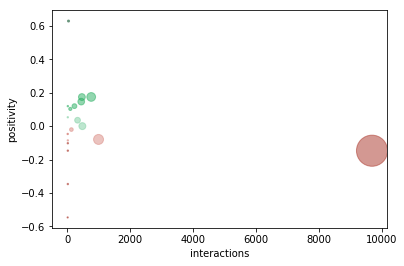

In [5]:
import numpy as np
import matplotlib.pyplot as plt

metrics = []
for f in friends:
    metrics.append(colp[f])
    
interactions = []
for f in friends:
    interactions.append(from_lengths[f] + to_lengths[f])

areas = []
for x in range(0, 20):
    areas.append(interactions[x] / 10)

mx = max(metrics)
mn = min(metrics)
rng = mx - mn

# range of HTML colors from dark red to dark green
color_range = ['#A93226', '#D98880', '#7DCEA0', '#27AE60', '#145A32']
colors = []
for x in range(0, 20):
    m = metrics[x]
    if m < -0.1:
        colors.append(color_range[0])
    elif m < 0:
        colors.append(color_range[1])
    elif m < 0.1:
        colors.append(color_range[2])
    elif m < 0.2:
        colors.append(color_range[3])
    else:
        colors.append(color_range[4])
        
plt.scatter(interactions, metrics, s=areas, c=colors, alpha=0.5)
plt.xlabel('interactions')
plt.ylabel('positivity')
plt.rcParams["figure.figsize"][0] = 10
plt.rcParams["figure.figsize"][1] = 7
plt.show()

The output is pretty interesting. In general, it looks like the people I interact with most are generally positive (with one exception). However, the output doesn't yet show a strong trend. I expect if I used all my friends instead of a subset I would get some more telling results. 